---
layout: post
title:  "Recurrent Neural Network"
date:   2023-03-15 10:14:54 +0700
categories: jekyll update
---

# TOC

- [Introduction](#intro)
- [RNN](#rnn)
- [LSTM](#lstm)
- [GRU](#gru)


# Introduction

Remember the threshold unit in the perceptron? A recurrent neuron is a neuron that apart from that feedforward part, it has connections backward. This wires it for sequential data such as time series, natural language, but not exclusively. For small dataset, a fully connected network can do the trick, and for huge dataset, a convolutional net is capable, too. For a time series recurrent network, the backward connection wires output/activation at time t-1 to be a part of input in time t. So this neuron carries information from the past (but not the future). Plus, the weights for input and previous output are shared among neurons.

In mathematical notations, let s be the combination of previous output and input, U, W, $$ \theta $$ are weights. Also, let use 30 neurons to output one final prediction, we would need to calculate the combination of input and previous output 30 times before we can activate the result:

$$ s_0 = 0 $$

$$ s_t = f(U * x_t + W * s_{t-1}, t >= 1 $$

$$ \hat{y} = h_{\theta} (\theta * s_{30}) $$

## Backpropagation through time

We propagate the loss back through the recurrent neurons as usual. Since those neurons are in time, this is called backpropagation throught time. We have 3 weight matrices: W,U, and $$ \theta$$. To descend the gradient, we need to find partial derivatives: $$ \frac{\partial Loss}{\partial U}, \frac{\partial Loss}{\partial V},\frac{\partial Loss}{\partial \theta} $$

$$ \frac{\partial L}{\partial \theta} = \frac{\partial L}{\partial \hat{y}}  \frac{\partial \hat{y}}{\partial \theta} $$

$$ \frac{\partial L}{\partial W} = \frac{\partial L}{\partial \hat{y}}  \frac{\partial \hat{y}}{\partial s_{30}}  \frac{\partial s_{30}}{\partial W} $$

with $$ s_{30} = f(W * s_{29} + V * x_{30}) $$

so $$ \frac{s_{30}}{\partial W} = s'_{30}(W) + \frac{\partial s_{30}}{\partial s_{29}}  \frac{\partial s_{29}}{\partial W} $$

$$ \Rightarrow  \frac{\partial L}{\partial W} = \sum_{i=0}^{30}  \frac{\partial L}{\partial \hat{y}}   \frac{\partial \hat{y}}{\partial s_{30}}  \frac{\partial s_{30}}{\partial s_i} + s'_i(W) $$ with $$ \frac{\partial s_{30}}{\partial s_i} = \prod_{j=i}^{29} \frac{\partial s_{j+1}}{\partial s_j} $$

Let's use RNN for a time series dataset that is about electric production:

In [11]:
import pandas as pd
# import tensorflow as tf
import matplotlib.pyplot as plt

df = pd.read_csv("Electric_Production.csv",parse_dates=["DATE"])
df.columns = ["date", "amount"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop_duplicates()
df


,amount
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


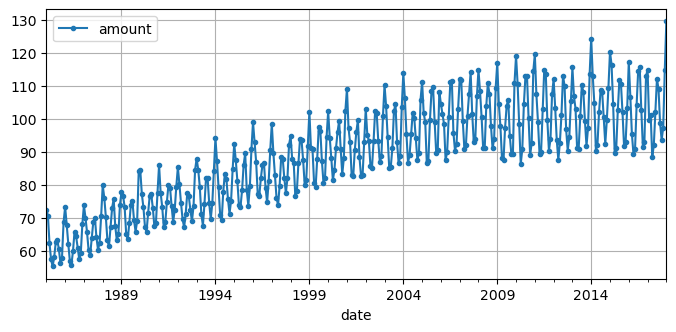

In [9]:
df.plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()


In [ ]:
# Simple RNN

# 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

df2 = pd.read_csv('/kaggle/input/time-series-datasets/Electric_Production.csv')
df2.columns = ["date", "amount"]  # shorter names
df2 = df2.sort_values("date").set_index("date")
df2 = df2.drop_duplicates()
df2
train = df2[:250]
test=df2[250:]

training_data = train

scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)

x_training_data = []
y_training_data =[]

for i in range(time_steps, len(training_data)):
    x_training_data.append(training_data[i-time_steps:i, 0])
    y_training_data.append(training_data[i, 0])

x_training_data = np.array(x_training_data)
y_training_data = np.array(y_training_data)

print(x_training_data.shape)
print(y_training_data.shape)

x_training_data = np.reshape(x_training_data, (x_training_data.shape[0], 
                                               x_training_data.shape[1], 
                                               1))
print(x_training_data.shape)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout

rnn = Sequential()
rnn.add(SimpleRNN(3, input_shape=(time_steps,1), activation="tanh"))
# rnn.add(LSTM(units = 45, return_sequences = True, input_shape = (x_training_data.shape[1], 1)))
rnn.add(Dropout(0.2))
# for i in [True, True, False]:
#     rnn.add(LSTM(units = 45, return_sequences = i))
#     rnn.add(Dropout(0.2))
rnn.add(Dense(units = 1))
rnn.compile(optimizer = 'adam', loss = 'mean_squared_error')
rnn.fit(x_training_data, y_training_data, epochs = 100, batch_size = 32)

test_data=test
print(test_data.shape)
plt.plot(test_data)

all_data=df2

x_test_data = all_data[len(all_data) - len(test_data) - time_steps:].values
x_test_data = np.reshape(x_test_data, (-1, 1))
x_test_data = scaler.transform(x_test_data)

final_x_test_data = []

for i in range(time_steps, len(x_test_data)):
    final_x_test_data.append(x_test_data[i-time_steps:i, 0])
final_x_test_data = np.array(final_x_test_data)

final_x_test_data = np.reshape(final_x_test_data, (final_x_test_data.shape[0], 
                                               final_x_test_data.shape[1], 
                                               1))
predictions = rnn.predict(final_x_test_data)

plt.clf() #This clears the old plot from our canvas

plt.plot(predictions)

unscaled_predictions = scaler.inverse_transform(predictions)
plt.clf() #This clears the first prediction plot from our canvas

plt.plot(unscaled_predictions)
plt.plot(unscaled_predictions, color = '#135485', label = "Predictions")
plt.plot(test_data, color = 'black', label = "Real Data")
plt.title('Electric Production Predictions')


Epoch 100/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0376

![rnn](https://user-images.githubusercontent.com/7457301/225573952-2d3dc1ae-73f6-416e-a097-099dd49445a5.png)

# LSTM - Long short term memory cell

To address the issue of the recurrent neuron in which it doesn't remember too long in the past, long short term memory neuron was architected. Apart from the current input, there is a thread of long term memory which carries recognized pattern. There is also a thread of short term memory which carries the information from the previous time step. Inside the cell, there are gates to control the flow of data. Since those gates use sigmoid function, they output 1 to open the gate and 0 to close the gate. There are usually 3 gates: forget gate, input gate and output gate. Those gates choose which pattern to forget, which new one to take into the long term memory thread, and it also controls how much of long term data should be used in this cell to output immediately.



In [ ]:
# 3

rnn = Sequential()
rnn.add(LSTM(units = 45, return_sequences = True, input_shape = (x_training_data.shape[1], 1)))
rnn.add(Dropout(0.2))
for i in [True, True, False]:
    rnn.add(LSTM(units = 45, return_sequences = i))
    rnn.add(Dropout(0.2))
rnn.add(Dense(units = 1))
rnn.compile(optimizer = 'adam', loss = 'mean_squared_error')
rnn.fit(x_training_data, y_training_data, epochs = 100, batch_size = 32)


Epoch 100/100
8/8 [==============================] - 0s 38ms/step - loss: 0.0193

![lstm](https://user-images.githubusercontent.com/7457301/225573947-f589aa41-1170-47e6-8e46-3a95ce9b1e0c.png)

Here is a LSTM that predicts the next 14 days of eletric production:

In [ ]:
rnn = Sequential()
rnn.add(LSTM(units = 45, return_sequences = True, input_shape = (x_training_data.shape[1], 1)))
rnn.add(Dropout(0.2))
for i in [True, True, False]:
    rnn.add(LSTM(units = 45, return_sequences = i))
    rnn.add(Dropout(0.2))
rnn.add(Dense(units = 14))
rnn.compile(optimizer = 'adam', loss = 'mean_squared_error')
rnn.fit(x_training_data, y_training_data, epochs = 100, batch_size = 32)


Epoch 100/100
8/8 [==============================] - 0s 38ms/step - loss: 0.0182

![lstm14](https://user-images.githubusercontent.com/7457301/225573937-8aa08490-719f-447b-90c2-928673bf4324.png)

# GRU - Gated recurrent unit

A GRU is similar to LSTM cell in which it has gates and a thread of memory. There is one gate to control which part of data should be recalled from the memory and which part should use the current input. It is a simplified LSTM.

In [ ]:
rnn = Sequential()
rnn.add(GRU(256, return_sequences=False))# 3
rnn.add(Dropout(0.2))
rnn.add(Dense(units = 1))
rnn.compile(optimizer = 'adam', loss = 'mean_squared_error')
rnn.fit(x_training_data, y_training_data, epochs = 100, batch_size = 32)


Epoch 100/100
8/8 [==============================] - 0s 30ms/step - loss: 0.0114

![gru](https://user-images.githubusercontent.com/7457301/225573951-fe95fd90-06e5-4940-96ab-1a1d3784ef2c.png)

GRU is the one that gives the best loss: 0.014